## Load Packages

In [61]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image, ImageEnhance, ImageOps
import re
import time
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import fashion_mnist

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Load Data

In [4]:
df = pd.read_csv('all_object_metadata_cleaned.csv')

print(df.shape)
df.head(5)

(37770, 9)


,session_id,category,age,num_strokes,draw_duration_old,draw_duration_new,mean_intensity,age_numeric,filename
0,cdm_run_v41542396376182,a bear,age10,3,3.234,0.0,0.027344,10,bear_sketch_age10_cdm_run_v41542396376182.png
1,cdm_run_v41542494477217,a bear,age10,13,16.261,0.0,0.051897,10,bear_sketch_age10_cdm_run_v41542494477217.png
2,cdm_run_v41542572319870,a bear,age10,1,0.000,0.0,0.025072,10,bear_sketch_age10_cdm_run_v41542572319870.png
3,cdm_run_v41543101092847,a bear,age10,13,11.540,0.0,0.031270,10,bear_sketch_age10_cdm_run_v41543101092847.png
4,cdm_run_v41543102904371,a bear,age10,6,8.674,0.0,0.026128,10,bear_sketch_age10_cdm_run_v41543102904371.png


In [5]:
zip_path = './stringent_cleaned_dataset.zip'

folder_path = './unzipped_dataset'  #extraction directory
os.makedirs(folder_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:    #unzip
    zip_ref.extractall(folder_path)

png_files = [os.path.join(root, f)
             for root, _, files in os.walk(folder_path)
             for f in files if f.endswith('.png')]     #find all PNG files recursively

print(png_files[:10])

['./unzipped_dataset/stringent_cleaned_dataset/book_sketch_age6_cdm_run_v61570317318221.png', './unzipped_dataset/stringent_cleaned_dataset/frog_sketch_age6_cdm_run_v41548448612180.png', './unzipped_dataset/stringent_cleaned_dataset/rabbit_sketch_age6_cdm_run_v31528836281409.png', './unzipped_dataset/stringent_cleaned_dataset/car_sketch_age5_cdm_run_v31534277725122.png', './unzipped_dataset/stringent_cleaned_dataset/camel_sketch_age6_cdm_run_v51552759892951.png', './unzipped_dataset/stringent_cleaned_dataset/ice cream_sketch_age3_cdm_run_v61565114112574.png', './unzipped_dataset/stringent_cleaned_dataset/elephant_sketch_age8_cdm_run_v61565387763689.png', './unzipped_dataset/stringent_cleaned_dataset/hat_sketch_age2_cdm_run_v51551570430178.png', './unzipped_dataset/stringent_cleaned_dataset/horse_sketch_age5_cdm_run_v61565989568583.png', './unzipped_dataset/stringent_cleaned_dataset/bee_sketch_age4_cdm_run_v71575149858827.png']


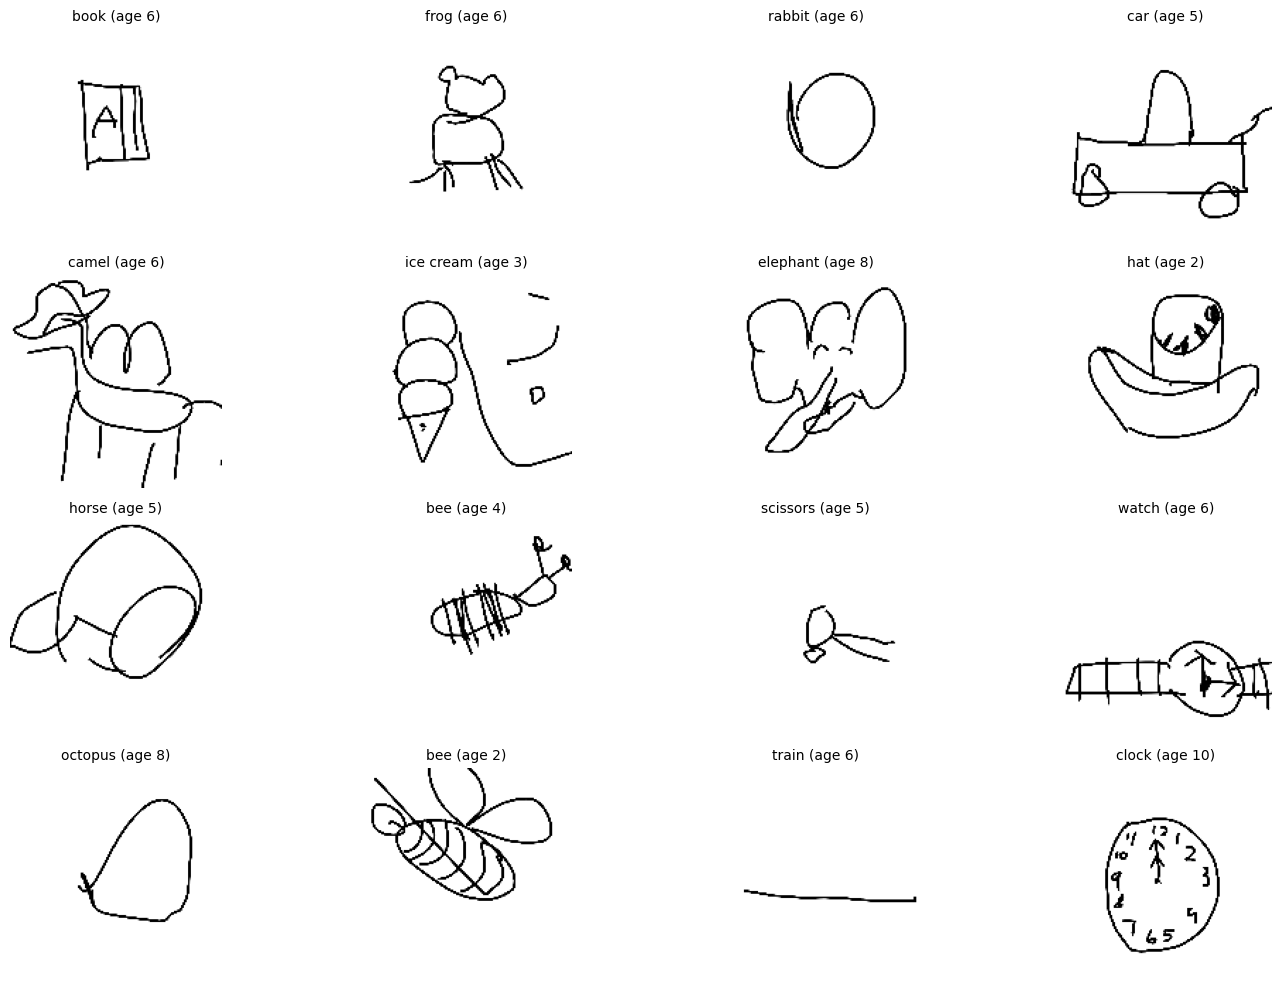

In [6]:
png_files1 = png_files[:16]   #sample images

fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = axes.flatten()

for ax, image_path in zip(axes, png_files1):
    img = Image.open(image_path)
    filename = os.path.basename(image_path)

    match = re.search(r"^(.*?)_sketch_age(\d+)", filename)   #keep icon drawn and age
    if match:
        icon_raw, age = match.groups()
        icon = icon_raw.replace('_', ' ') 
        title = f"{icon} (age {age})"
    else:
        title = filename

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## EDA and Data Cleaning

In [8]:
#drop unnecessary columns
columns_to_drop = ['draw_duration_new', 'mean_intensity']
df = df.drop(columns=columns_to_drop)

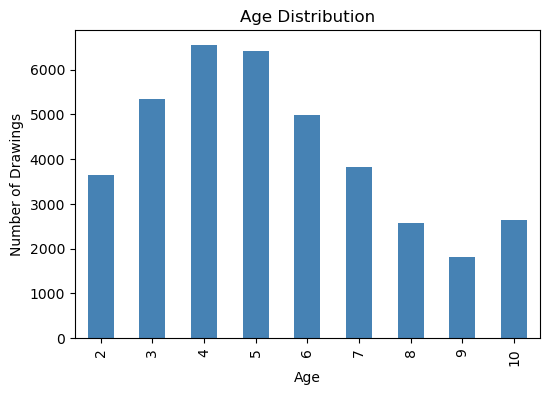

In [9]:
#plot age distribution
plt.figure(figsize=(6, 4))
df['age_numeric'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Drawings")
plt.show()

In [10]:
def age_group(age):
    if age <= 4:
        return '2-4yo'
    elif age <= 7:
        return '5-7yo'
    else:
        return '8-10yo'

df['age_group'] = df['age_numeric'].apply(age_group)

df.head(10)

,session_id,category,age,num_strokes,draw_duration_old,age_numeric,filename,age_group
0,cdm_run_v41542396376182,a bear,age10,3,3.234,10,bear_sketch_age10_cdm_run_v41542396376182.png,8-10yo
1,cdm_run_v41542494477217,a bear,age10,13,16.261,10,bear_sketch_age10_cdm_run_v41542494477217.png,8-10yo
2,cdm_run_v41542572319870,a bear,age10,1,0.000,10,bear_sketch_age10_cdm_run_v41542572319870.png,8-10yo
3,cdm_run_v41543101092847,a bear,age10,13,11.540,10,bear_sketch_age10_cdm_run_v41543101092847.png,8-10yo
4,cdm_run_v41543102904371,a bear,age10,6,8.674,10,bear_sketch_age10_cdm_run_v41543102904371.png,8-10yo
5,cdm_run_v41543792731223,a bear,age10,32,21.987,10,bear_sketch_age10_cdm_run_v41543792731223.png,8-10yo
6,cdm_run_v41543949996080,a bear,age10,9,13.846,10,bear_sketch_age10_cdm_run_v41543949996080.png,8-10yo
7,cdm_run_v41544050821555,a bear,age10,8,4.204,10,bear_sketch_age10_cdm_run_v41544050821555.png,8-10yo
8,cdm_run_v41544121857609,a bear,age10,5,4.895,10,bear_sketch_age10_cdm_run_v41544121857609.png,8-10yo
9,cdm_run_v41544301177315,a bear,age10,13,16.388,10,bear_sketch_age10_cdm_run_v41544301177315.png,8-10yo


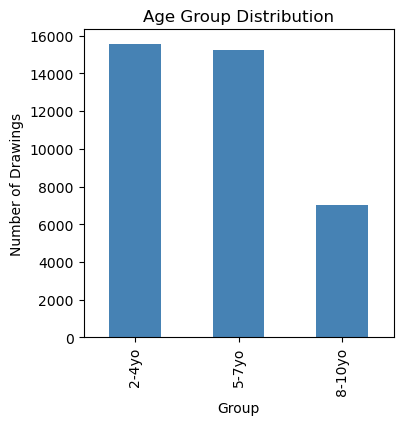

In [11]:
#plot age group distribution
plt.figure(figsize=(4, 4))
df['age_group'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Age Group Distribution")
plt.xlabel("Group")
plt.ylabel("Number of Drawings")
plt.show()

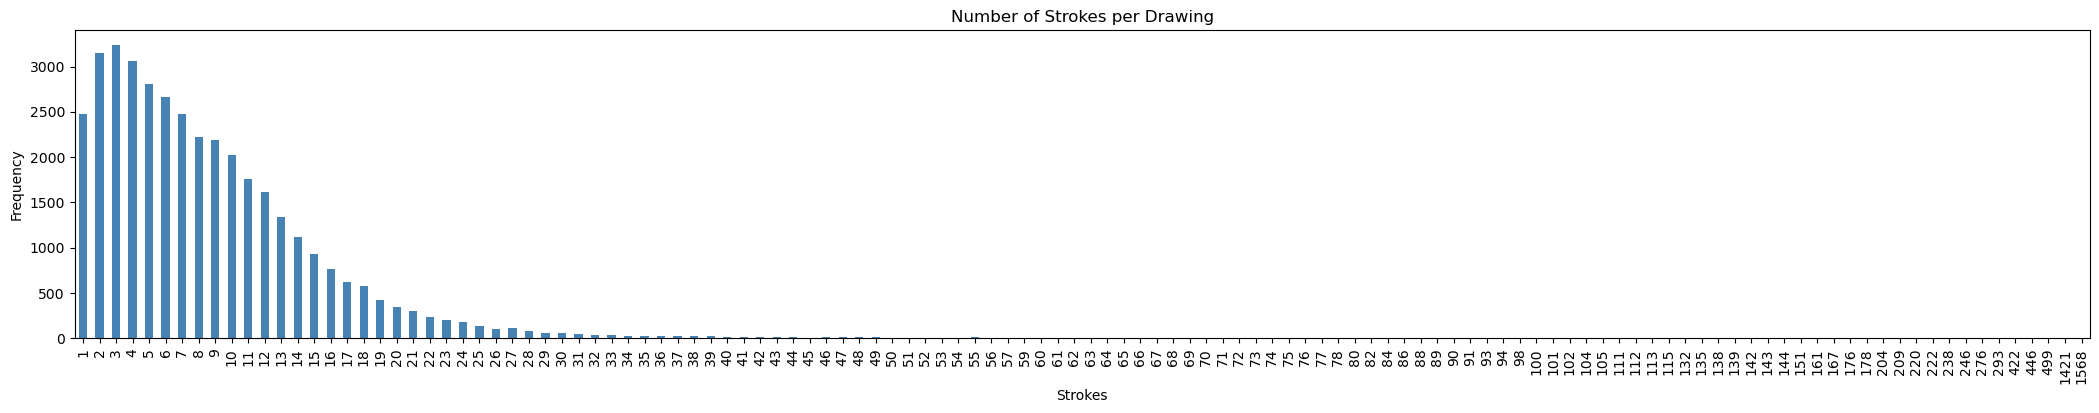

In [12]:
#plot stroke count distribution
plt.figure(figsize=(26, 4))
df['num_strokes'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Number of Strokes per Drawing")
plt.xlabel("Strokes")
plt.ylabel("Frequency")
plt.show()

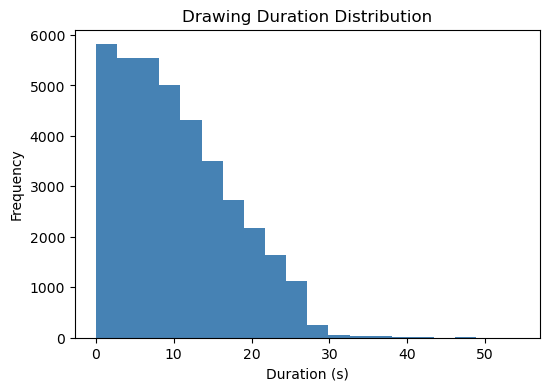

In [13]:
#plot drawing times
plt.figure(figsize=(6, 4))
plt.hist(df['draw_duration_old'], bins=20, color='steelblue')
plt.title("Drawing Duration Distribution")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.show()

#### Evaluating strokes per Age group

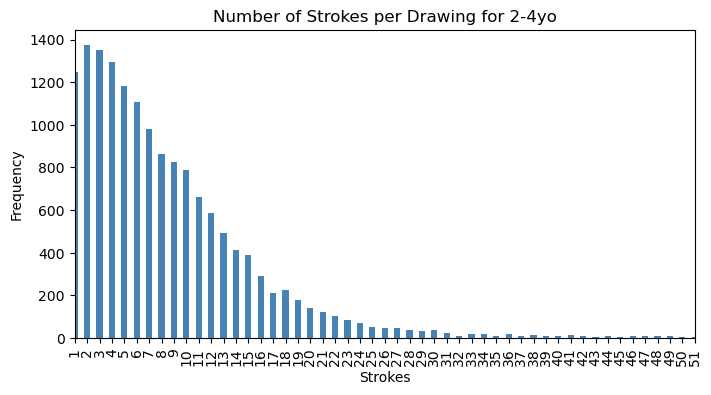

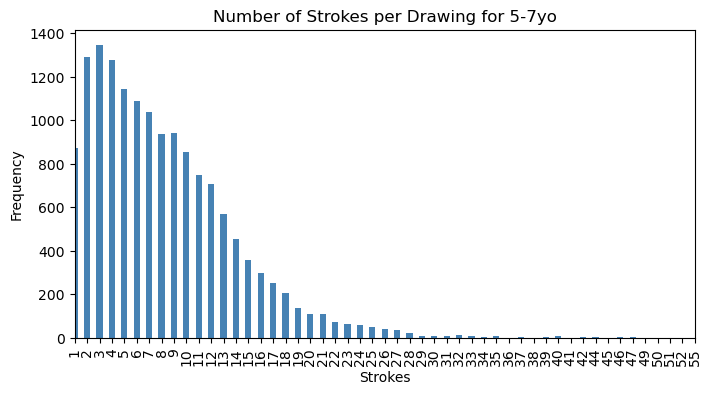

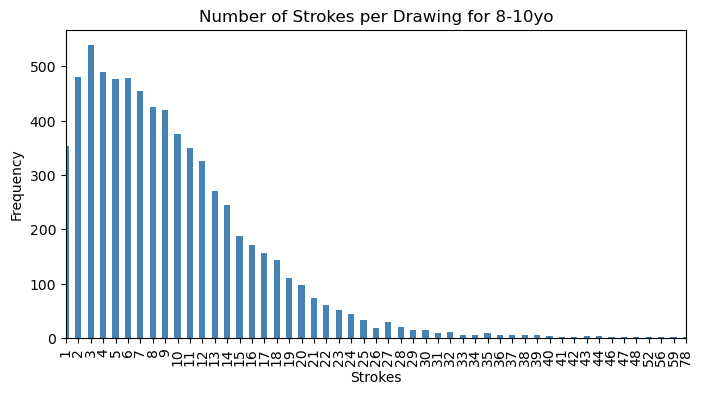

In [15]:
age_groups = ['2-4yo', '5-7yo', '8-10yo']
for grp in age_groups:
    subset = df[df['age_group'] == grp]
    counts = subset['num_strokes'].value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar', color='steelblue')
    plt.title(f"Number of Strokes per Drawing for {grp}")
    plt.xlabel("Strokes")
    plt.ylabel("Frequency")
    plt.xlim(0, 50)
    plt.show()

In [16]:
avg_strokes = df.groupby('age_group')['num_strokes'].mean().reset_index()
avg_strokes.columns = ['age_group', 'avg_num_strokes']

print(avg_strokes)

  age_group  avg_num_strokes
0     2-4yo         8.983218
1     5-7yo         8.449271
2    8-10yo         9.518143


In [17]:
percentile_threshold = 0.10   #remove bottom 10% drawings

stroke_cutoffs = (
    df.groupby('age_group')['num_strokes']
    .quantile(percentile_threshold)
    .to_dict()
)

df = df[df.apply(lambda row: row['num_strokes'] >= stroke_cutoffs[row['age_group']], axis=1)]

#additional cleaning
df = df[df['draw_duration_old'] > 0.0]   #remove 0s drawings
df = df[df['num_strokes'] < 41]          #remove extremely high stroke counts

df.shape

(35064, 8)

### Data Balancing

In [18]:
df['age_group'].value_counts()

age_group
5-7yo     14303
2-4yo     14139
8-10yo     6622
Name: count, dtype: int64

In [19]:
min_size = df['age_group'].value_counts().min()   #size of the smallest group

balanced_df = df.groupby('age_group').sample(n=min_size, random_state=42)   #sample equal number from each group
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df['age_group'].value_counts()

age_group
5-7yo     6622
8-10yo    6622
2-4yo     6622
Name: count, dtype: int64

## Data Preprocessing

In [21]:
image_folder = './unzipped_dataset/stringent_cleaned_dataset'

image_size = (128, 128)

balanced_df['filename'] = balanced_df['filename'].astype(str).str.strip()

#load and preprocess each image
def load_and_preprocess_image(filename, target_size=(128, 128)):
    path = os.path.join(image_folder, filename)
    with Image.open(path) as img:
        img = img.convert("RGBA")
        bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
        img = Image.alpha_composite(bg, img).convert("L")      #grayscale

        img = img.resize(target_size)
        img_array = np.asarray(img, dtype=np.float32) / 255.0
        #img_array = 1.0 - img_array  #for inverting --> black background & white strokes
        return img_array


images = balanced_df['filename'].apply(load_and_preprocess_image)
labels = balanced_df.loc[images.index, 'age_group'].values
image_data = np.stack(images.values)
image_data = np.expand_dims(image_data, axis=-1)  #reshape 4D (N, 128, 128, 1)

In [22]:
#LABEL ENCODING
#categorical (for CNN) and encoded (for sklearn)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(balanced_df['age_group'])
y_categorical = to_categorical(y_encoded)          #creates (N, num_classes)

In [23]:
#flatten and scale for baselines
X_flat = image_data.reshape((image_data.shape[0], -1))    #shape (N, 16384)
X_scaled = StandardScaler().fit_transform(X_flat)              

### Data Splitting

In [24]:
#consistent split for all relevant models
X_train_raw, X_temp_raw, y_train_cat, y_temp_cat, X_train_scaled, X_temp_scaled, y_train_enc, y_temp_enc = train_test_split(
    image_data, y_categorical, X_scaled, y_encoded,
    test_size=0.3, stratify=y_encoded, random_state=42
)

X_val_raw, X_test_raw, y_val_cat, y_test_cat, X_val_scaled, X_test_scaled, y_val_enc, y_test_enc = train_test_split(
    X_temp_raw, y_temp_cat, X_temp_scaled, y_temp_enc,
    test_size=0.5, stratify=y_temp_enc, random_state=42
)

#shapes
print("CNN Train:", X_train_raw.shape)
print("CNN Val:  ", X_val_raw.shape)
print("CNN Test: ", X_test_raw.shape)
print("\n")
print("Baseline Train:", X_train_scaled.shape)
print("Baseline Val:  ", X_val_scaled.shape)
print("Baseline Test: ", X_test_scaled.shape)

# CNN: X_train_raw, y_train_cat (with train_datagen)
# RF/SVM: X_train_scaled, y_train_enc

CNN Train: (13906, 128, 128, 1)
CNN Val:   (2980, 128, 128, 1)
CNN Test:  (2980, 128, 128, 1)


Baseline Train: (13906, 16384)
Baseline Val:   (2980, 16384)
Baseline Test:  (2980, 16384)


### Data Augmentation for Training Set

In [26]:
#augmentation (for training)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

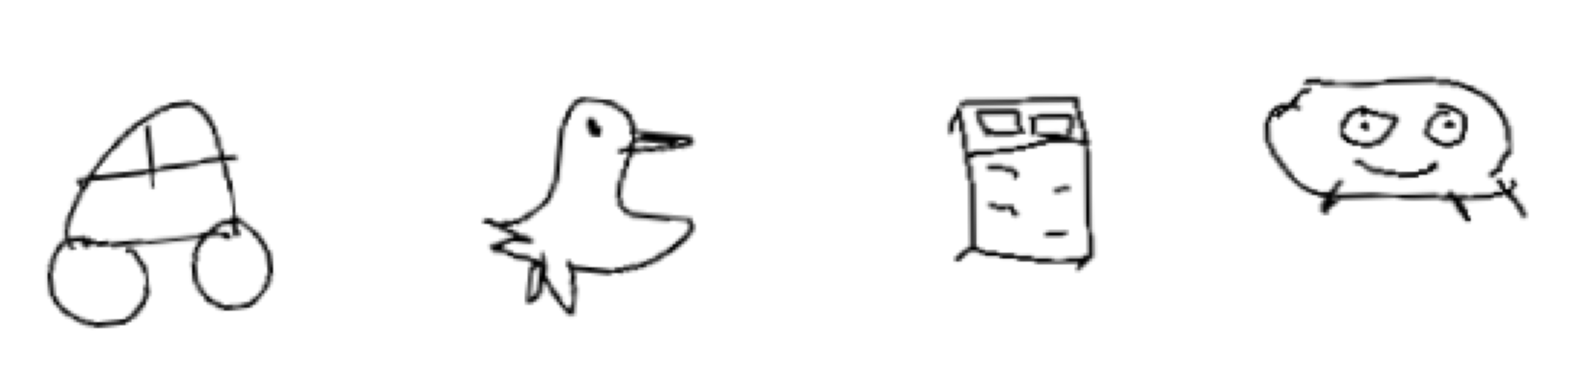

In [28]:
#example of augmented images 
batch_x, batch_y = next(train_datagen.flow(X_train_raw, y_train_cat, batch_size=4))

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(batch_x[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Modelling Framework

## Baseline Model - PCA + RF

In [33]:
#apply PCA on scaled training data 
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_train = y_train_enc
y_val = y_val_enc
y_test = y_test_enc

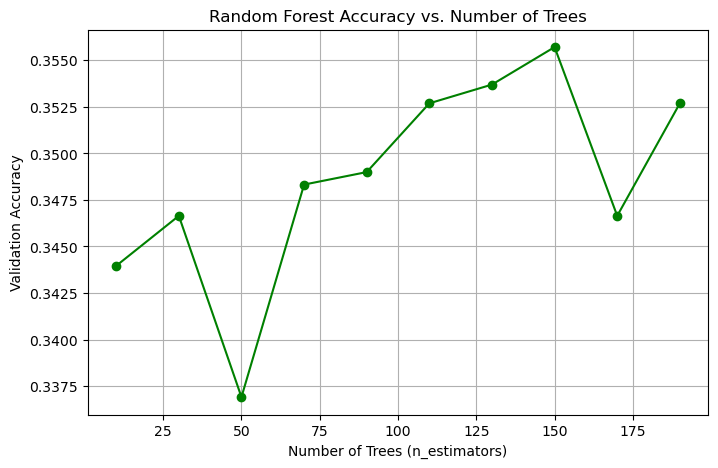

Best n_estimators: 150 with accuracy: 0.3557
RF Training Time: 115.93 seconds
Random Forest Classification Report:
               precision    recall  f1-score   support

       2-4yo       0.34      0.36      0.35       993
       5-7yo       0.34      0.34      0.34       994
      8-10yo       0.34      0.32      0.33       993

    accuracy                           0.34      2980
   macro avg       0.34      0.34      0.34      2980
weighted avg       0.34      0.34      0.34      2980



In [35]:
#random forest
n_estimators_range = range(10, 201, 20)
rf_accuracies = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_val_pca)
    rf_accuracies.append(accuracy_score(y_val, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, rf_accuracies, marker='o', color='green')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

best_n = n_estimators_range[rf_accuracies.index(max(rf_accuracies))]
print(f"Best n_estimators: {best_n} with accuracy: {max(rf_accuracies):.4f}")

rf = RandomForestClassifier(n_estimators=best_n, random_state=100)

start = time.time()
rf.fit(X_train_pca, y_train)
end = time.time()
print(f"RF Training Time: {end - start:.2f} seconds")

y_pred_rf = rf.predict(X_test_pca)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

## SVM

In [37]:
svm = SVC(C=1.0, gamma='scale', kernel='rbf', probability=True, random_state=100)

start = time.time()
svm.fit(X_train_pca, y_train)
end = time.time()

print(f"SVM Training Time: {end - start:.2f} seconds")

y_pred_svm = svm.predict(X_test_pca)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

probs = svm.predict_proba(X_test_pca)
confidences = np.max(probs, axis=1)

SVM Training Time: 3037.23 seconds
SVM Classification Report:
               precision    recall  f1-score   support

       2-4yo       0.39      0.45      0.42       993
       5-7yo       0.37      0.35      0.36       994
      8-10yo       0.38      0.35      0.36       993

    accuracy                           0.38      2980
   macro avg       0.38      0.38      0.38      2980
weighted avg       0.38      0.38      0.38      2980



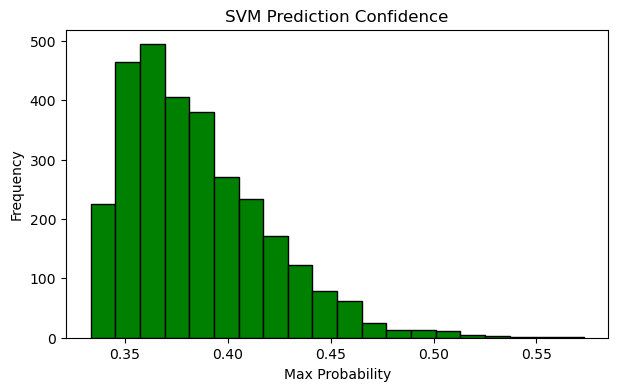

In [38]:
plt.figure(figsize=(7, 4))
plt.hist(confidences, bins=20, color='green', edgecolor='black')
plt.title("SVM Prediction Confidence")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.show()

## CNN

### Shallow CNN (with no augmentation)

In [63]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Dropout(0.25),
    GlobalAveragePooling2D(),
    #or Flatten()

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-4)
checkpoint = ModelCheckpoint('cnn_shallow.keras', monitor='val_loss', save_best_only=True)

#train
start = time.time()
history = model.fit(
    X_train_raw, y_train_cat,
    validation_data=(X_val_raw, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)
print("Train time:", round(time.time() - start), "seconds")

loss, acc = model.evaluate(X_test_raw, y_test_cat)
print("Test accuracy:", acc)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.3267 - loss: 1.1019 - val_accuracy: 0.3396 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.3457 - loss: 1.0979 - val_accuracy: 0.3356 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.3509 - loss: 1.0973 - val_accuracy: 0.3601 - val_loss: 1.0962 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 44s 200ms/step - accuracy: 0.3671 - loss: 1.0955 - val_accuracy: 0.3755 - val_loss: 1.0948 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.3649 - loss: 1.0945 - val_accuracy: 0.3732 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.3766 - loss: 1.0918 - val_accuracy: 0.3735 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 44s 200ms/step - accuracy: 0.3

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Classification Report:
              precision    recall  f1-score   support

       2-4yo       0.42      0.64      0.50       993
       5-7yo       0.39      0.12      0.18       994
      8-10yo       0.43      0.50      0.46       993

    accuracy                           0.42      2980
   macro avg       0.41      0.42      0.38      2980
weighted avg       0.41      0.42      0.38      2980



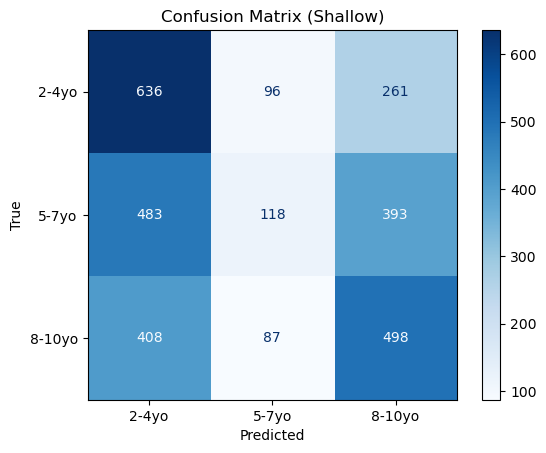

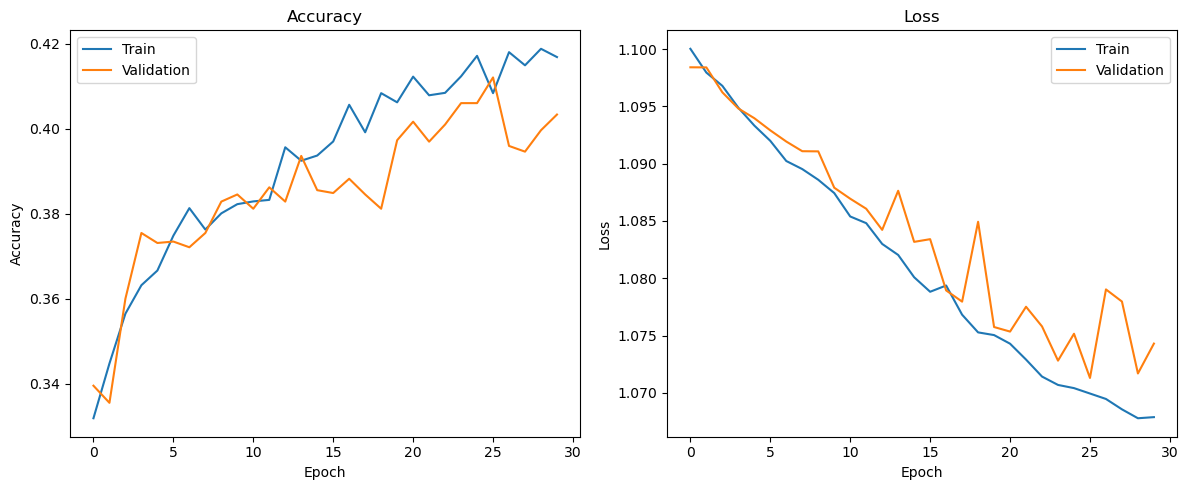

In [64]:
model = load_model("cnn_shallow.keras")  #best model

y_pred_probs = model.predict(X_test_raw)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Shallow)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Deep CNN

In [183]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4), input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2),
    SpatialDropout2D(0.2),

    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2),
    SpatialDropout2D(0.3),

    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2),
    SpatialDropout2D(0.3),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4),
    ModelCheckpoint(filepath="cnn_deep.keras", monitor='val_loss', save_best_only=True, verbose=1)]

#training
start = time.time()
history = model.fit(
    train_datagen.flow(X_train_raw, y_train_cat, batch_size=64),
    validation_data=val_datagen.flow(X_val_raw, y_val_cat, batch_size=64, shuffle=False),
    epochs=40,
    callbacks=callbacks
)
print("Train time:", round(time.time() - start), "seconds")

loss, acc = model.evaluate(X_test_raw, y_test_cat)
print("Test accuracy:", acc)

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.3430 - loss: 1.2602
Epoch 1: val_loss improved from inf to 1.38953, saving model to cnn_deep.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 199s 908ms/step - accuracy: 0.3430 - loss: 1.2598 - val_accuracy: 0.3332 - val_loss: 1.3895 - learning_rate: 0.0010
Epoch 2/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.3626 - loss: 1.1471
Epoch 2: val_loss improved from 1.38953 to 1.17217, saving model to cnn_deep.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 213s 977ms/step - accuracy: 0.3626 - loss: 1.1471 - val_accuracy: 0.3460 - val_loss: 1.1722 - learning_rate: 0.0010
Epoch 3/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3733 - loss: 1.1402
Epoch 3: val_loss did not improve from 1.17217
218/218 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.3733 - loss: 1.1402 - val_accuracy: 0.3436 - val_loss: 1.1818 - learning_rate: 0.0010
Epoch 4/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.3861 - loss: 1.1328
Epoch 4: val_loss did

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step

Classification Report:
              precision    recall  f1-score   support

       2-4yo       0.44      0.63      0.52       993
       5-7yo       0.40      0.24      0.30       994
      8-10yo       0.46      0.46      0.46       993

    accuracy                           0.44      2980
   macro avg       0.44      0.44      0.43      2980
weighted avg       0.44      0.44      0.43      2980



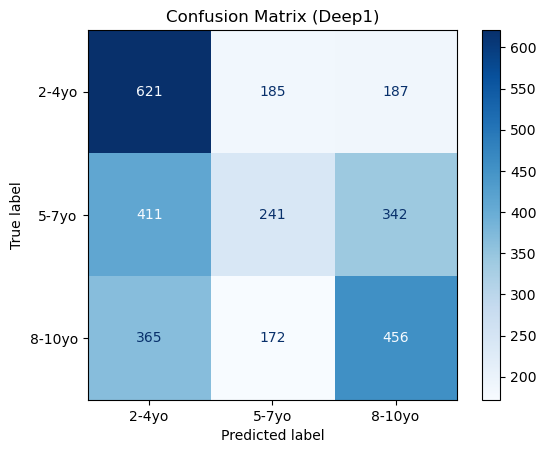

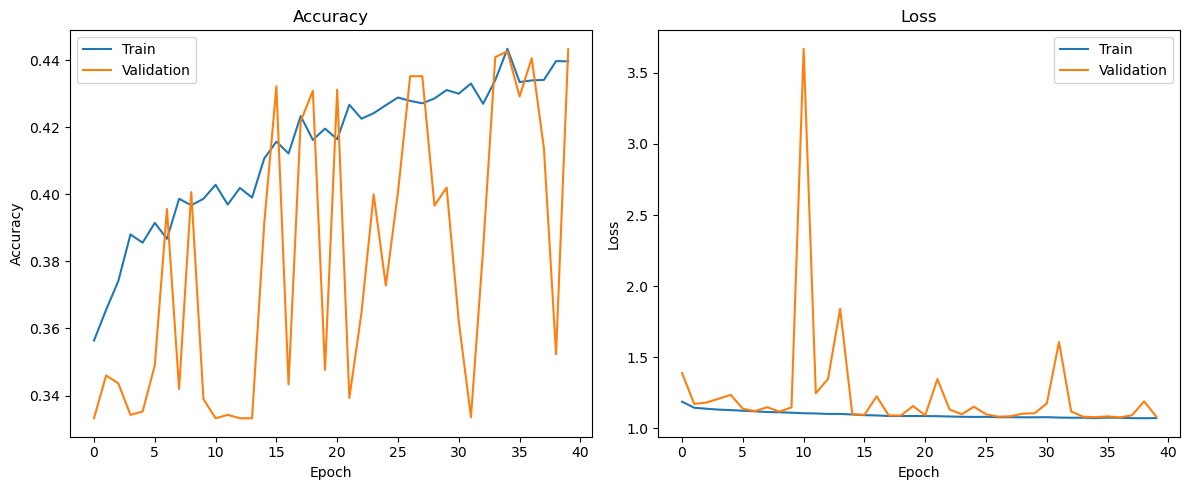

In [184]:
model = load_model("cnn_deep.keras")

y_pred_probs = model.predict(X_test_raw)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Deep1)")
plt.show()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Training Times

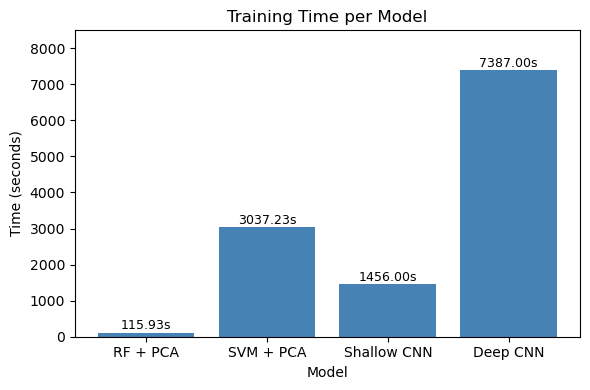

In [66]:
training_times = {
    'RF + PCA': 115.93,
    'SVM + PCA': 3037.23,
    'Shallow CNN': 1456,
    'Deep CNN': 7387
}

# Data for plotting
models = list(training_times.keys())
times = list(training_times.values())

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, times, color='steelblue')
plt.title("Training Time per Model")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")

# Annotate bars with actual values
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f"{time:.2f}s", ha='center', va='bottom', fontsize=9)

plt.ylim(0, max(times) * 1.15)
plt.tight_layout()
plt.show()


### Model Summary

| Model   | Test Acc |  Val Var | Regularization       | Augmentation   |                                                          |
| ------- | -------- | ------- | -------------------- | -------------- | --------------------------------------------------------------- |
| **RF**      | 0.34     |  Low-Med | Implicit (trees)     | no           | Flat recall across classes, stable but weak                     |
| **SVM**     | 0.38     | Low     | RBF kernel, C=1      | no           | More balanced, low but even recall, confidence is weak |
| **Shallow CNN** | 0.42     | Low     | Dropout(0.3), no BN  | no | Learns distinct age patterns, but underfits middle group        |
| **Deep CNN**   | 0.44     | High  | Dropout(0.4), BN, L2 | (train only) |  Highest accuracy but highly unstable |
